# 1. 문제 정의

* 문제 상황 : 디미는 아이돌이 되기 위해 자신이 그룹과 솔로 중 어디에 어울릴지 고민하고 있다. 또, 그룹이라면 몇 인조 그룹에 어울리는지가 궁금하다.

* 문제 정의 : 지금까지의 K-POP 아이돌들의 정보를 분석하여 디미가 몇 인조로 데뷔해야 할지 알려주자.

# 2. 데이터 수집

* 데이터 수집 출처 : [K-Pop Database (1992-2020)](https://www.kaggle.com/kimjihoo/kpopdb)

* 파일명 : kpop_idols.csv

* 독립변수 : 10개
  * Stage Name : 무대명
  * Full Name : 실명
  * Korean Name : 한국명
  * K. Stage Name : 한국 무대명
  * Date of Birth : 생년월일
  * Group : 그룹명
  * Country : 국적
  * Birthplace : 출생지
  * Other Group : 다른 그룹명
  * Gender : 성별

In [1]:
# 데이터 가져오기
import numpy as np
import pandas as pd

df = pd.read_csv('./kpop/kpop_idols.csv')
df.shape

(1310, 10)

In [2]:
# 열 정보 살펴보기
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1310 entries, 0 to 1309
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Stage Name     1310 non-null   object
 1   Full Name      1304 non-null   object
 2   Korean Name    1304 non-null   object
 3   K. Stage Name  1309 non-null   object
 4   Date of Birth  1310 non-null   object
 5   Group          1219 non-null   object
 6   Country        1310 non-null   object
 7   Birthplace     689 non-null    object
 8   Other Group    122 non-null    object
 9   Gender         1310 non-null   object
dtypes: object(10)
memory usage: 102.5+ KB


# 3. 데이터 전처리

### 불필요한 속성 삭제하기

In [3]:
df.drop(['Stage Name', 'Full Name', 'Korean Name', 'K. Stage Name', 'Birthplace'], axis=1, inplace=True)
df.columns

Index(['Date of Birth', 'Group', 'Country', 'Other Group', 'Gender'], dtype='object')

* unique한 데이터가 많아 처리가 어려운 이름 및 출생지 컬럼을 drop하였다.

### 결측치 확인 후 처리하기

In [4]:
# 결측치 개수
df.isnull().sum()

Date of Birth       0
Group              91
Country             0
Other Group      1188
Gender              0
dtype: int64

* Group이 없으면 솔로 가수이고 Other Group이 있으면 여러 그룹에서 활동한 아이돌이다.

### 데이터 변환하기

* object형인 생년월일 변환

* 범주형 데이터 변환

In [5]:
# 생년/월/일을 각각 int로 컬럼 생성
birth = [i.split('-') for i in df['Date of Birth']]
df['bYear'] = [int(i[0]) for i in birth]
df['bMonth'] = [int(i[1]) for i in birth]
df['bDay'] = [int(i[2]) for i in birth]
df.drop('Date of Birth', axis=1, inplace=True)
df.head()

,Group,Country,Other Group,Gender,bYear,bMonth,bDay
0,Limitless,South Korea,NaN,M,1996,12,31
1,VAV,South Korea,NaN,M,1992,8,28
2,Hashtag,South Korea,NaN,F,1999,10,25
3,MOMOLAND,South Korea,NaN,F,1999,9,27
4,Favorite,South Korea,NaN,F,2001,2,21


In [6]:
# 범주형 데이터 변환하기 (원핫 인코딩)
df = pd.get_dummies(df, columns=['Country', 'Gender'])
df.head()

,Group,Other Group,bYear,bMonth,bDay,Country_Australia,Country_Canada,Country_China,Country_Hong Kong,Country_Indonesia,Country_Japan,Country_Malaysia,Country_Philippines,Country_South Korea,Country_Taiwan,Country_Thailand,Country_USA,Gender_F,Gender_M
0,Limitless,NaN,1996,12,31,0,0,0,0,0,0,0,0,1,0,0,0,0,1
1,VAV,NaN,1992,8,28,0,0,0,0,0,0,0,0,1,0,0,0,0,1
2,Hashtag,NaN,1999,10,25,0,0,0,0,0,0,0,0,1,0,0,0,1,0
3,MOMOLAND,NaN,1999,9,27,0,0,0,0,0,0,0,0,1,0,0,0,1,0
4,Favorite,NaN,2001,2,21,0,0,0,0,0,0,0,0,1,0,0,0,1,0


### 종속변수 생성하기

In [7]:
# 그룹별 인원수 구하기
group = df.Group
gCount = group.value_counts().to_dict()  # 그룹별 인원수 딕셔너리
other = df['Other Group']
for i in other.dropna():
  for g in i.split(','):
    g=g.strip()
    if g in gCount:
      gCount[g] += 1
    else:
      gCount[g] = 1
gCount['IZ*ONE']  # 12명

12

In [8]:
# 인원수 컬럼 생성
pCount = []
for i in range(len(df)):
  c = 0
  if group[i]==group[i]: # NaN 판별
    c = gCount[group[i]]
    if other[i]==other[i]:  # 여러 그룹에 속해 있었다면 평균을 냄
      others = other[i].split(',')
      for g in others:
        g=g.strip()
        c += gCount[g]
      c /= len(others)+1
  else:  # 솔로 가수
    c = 1
  pCount.append(c)
df['pCount'] = pCount
df.drop(['Group', 'Other Group'], axis=1, inplace=True)
df.head()

,bYear,bMonth,bDay,Country_Australia,Country_Canada,Country_China,Country_Hong Kong,Country_Indonesia,Country_Japan,Country_Malaysia,Country_Philippines,Country_South Korea,Country_Taiwan,Country_Thailand,Country_USA,Gender_F,Gender_M,pCount
0,1996,12,31,0,0,0,0,0,0,0,0,1,0,0,0,0,1,4.0
1,1992,8,28,0,0,0,0,0,0,0,0,1,0,0,0,0,1,7.0
2,1999,10,25,0,0,0,0,0,0,0,0,1,0,0,0,1,0,7.0
3,1999,9,27,0,0,0,0,0,0,0,0,1,0,0,0,1,0,9.0
4,2001,2,21,0,0,0,0,0,0,0,0,1,0,0,0,1,0,6.0


# 4. 데이터 탐색 및 시각화

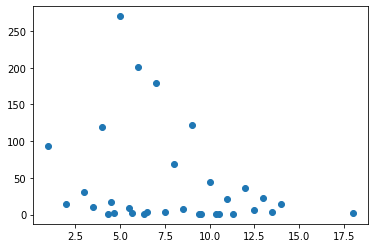

In [9]:
# 인원수 분포 확인하기
import matplotlib.pyplot as plt
import seaborn as sns
vc = df['pCount'].value_counts()
plt.scatter(vc.index, vc)
plt.show()

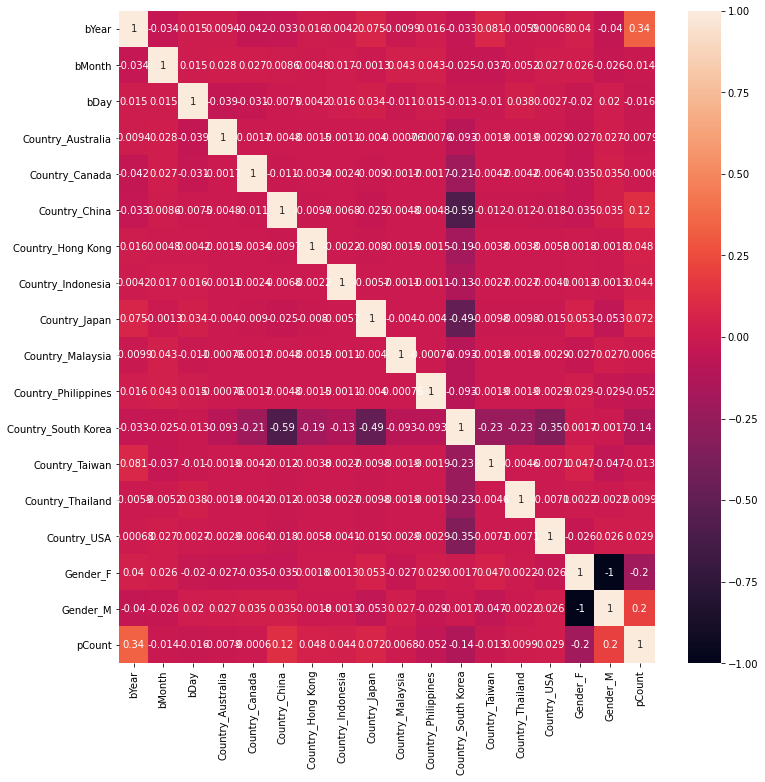

In [10]:
# 특성별 상관관계 보기
plt.figure(figsize=(12, 12))
sns.heatmap(df.corr(), annot=True)
plt.show()

# 5. 모델 학습 및 평가

* 머신러닝 알고리즘 선택 : 선형회귀 및 앙상블 학습

* 학습 후 가중치, 절편을 확인

* 분류 모델 평가 지표 : 평균 제곱 오차 제곱근(RMSE, Root Mean Squared Error)

In [11]:
# 독립변수, 종속변수 나누기
X = df.drop('pCount', axis=1)
y = df['pCount'].to_numpy()
X, y

(      bYear  bMonth  bDay  Country_Australia  Country_Canada  Country_China  \
 0      1996      12    31                  0               0              0   
 1      1992       8    28                  0               0              0   
 2      1999      10    25                  0               0              0   
 3      1999       9    27                  0               0              0   
 4      2001       2    21                  0               0              0   
 ...     ...     ...   ...                ...             ...            ...   
 1305   1997       6    16                  0               0              0   
 1306   1994       6     9                  0               0              0   
 1307   2005       5    31                  0               0              0   
 1308   1996       7     4                  0               0              0   
 1309   1994      12     8                  0               0              0   
 
       Country_Hong Kong  Country_Indo

In [12]:
# 학습/테스트 데이터 나누기
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train.shape, X_test.shape

((1048, 17), (262, 17))

In [13]:
# 선형회귀 학습하기
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [14]:
# 선형회귀 예측하기
pred = lr.predict(X_test)

from sklearn.metrics import mean_squared_error
def RMSE(y_real, y_pred):
  return np.sqrt(mean_squared_error(y_real, y_pred))

print('RMSE:', RMSE(y_test, pred))

pd.DataFrame({
  'y_test': y_test,
  'pred': pred,
  'error': y_test - pred
})

RMSE: 2.562138024706358


,y_test,pred,error
0,5.0,7.779317,-2.779317
1,6.0,7.111681,-1.111681
2,5.0,5.854036,-0.854036
3,4.0,7.540790,-3.540790
4,6.0,6.241556,-0.241556
...,...,...,...
257,1.0,4.311225,-3.311225
258,6.0,6.658169,-0.658169
259,9.0,7.504249,1.495751
260,7.0,5.647008,1.352992


In [15]:
lr.coef_, lr.intercept_

(array([ 0.24777304,  0.01024682, -0.01135843, -1.97609008,  0.23561486,
         2.22894149,  2.09217122,  3.04926775,  1.18191299,  0.34896123,
        -5.4005508 , -0.21392422, -1.60475657, -0.07991281,  0.13836495,
        -0.57535635,  0.57535635]),
 -487.97041107248447)

In [16]:
# 앙상블 학습 - AdaBoostRegressor가 가장 좋은 점수를 보였다.
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

lr = LinearRegression()
ada = AdaBoostRegressor(base_estimator=lr, n_estimators=100, random_state=0)
bag = BaggingRegressor(base_estimator=lr, n_estimators=100, random_state=0)
ext = ExtraTreesRegressor(n_estimators=100, random_state=0)
gbr = GradientBoostingRegressor(n_estimators=100, random_state=0)
rfr = RandomForestRegressor(n_estimators=100, random_state=0)

In [17]:
ada.fit(X_train, y_train)
bag.fit(X_train, y_train)
ext.fit(X_train, y_train)
gbr.fit(X_train, y_train)
rfr.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

In [18]:
ada_pred = ada.predict(X_test)
bag_pred = bag.predict(X_test)
ext_pred = ext.predict(X_test)
gbr_pred = gbr.predict(X_test)
rfr_pred = rfr.predict(X_test)

In [19]:
ada_score = RMSE(y_test, ada_pred)
bag_score = RMSE(y_test, bag_pred)
ext_score = RMSE(y_test, ext_pred)
gbr_score = RMSE(y_test, gbr_pred)
rfr_score = RMSE(y_test, rfr_pred)
print('RMSE:', ada_score, bag_score, ext_score, gbr_score, rfr_score)

RMSE: 2.534205009075829 2.563064894028971 3.055881371631621 2.5821071502689703 2.8670052387907465


In [20]:
# LR GridSearch
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer  # RMSE scoring을 위함
RMSE_scorer = make_scorer(RMSE, greater_is_better=False)

lr = LinearRegression()
lr_params={
  'fit_intercept': [True, False],  # 절편 사용 여부
  'positive': [True, False]  # 계수를 양수로만 설정할지 여부
}
gs = GridSearchCV(lr, lr_params, n_jobs=-1, scoring=RMSE_scorer)
gs.fit(X_train, y_train)

print('best parameter:', gs.best_params_)
print('best score:', gs.best_score_)
print(gs.score(X_train, y_train))
print(gs.score(X_test, y_test))

best parameter: {'fit_intercept': True, 'positive': False}
best score: -2.6139452097169276
-2.552095495550503
-2.562138024706358


In [21]:
# ABR GridSearch
lr = LinearRegression(fit_intercept=False, positive=False)
ada = AdaBoostRegressor(base_estimator=lr, n_estimators=100, random_state=0)
ada_params={
  'n_estimators': [50, 100, 150],
  'learning_rate': [0.5, 1, 1.5]
}
gs = GridSearchCV(ada, ada_params, n_jobs=-1, scoring=RMSE_scorer)
gs.fit(X_train, y_train)

print('best parameter:', gs.best_params_)
print('best score:', gs.best_score_)
print(gs.score(X_train, y_train))
print(gs.score(X_test, y_test))

best parameter: {'learning_rate': 0.5, 'n_estimators': 50}
best score: -4.745653766512833
-2.563042633208973
-2.558998761451719


* AdaBoostRegressor가 LinearRegression에 비해 좋은 성능을 보였다!

# 6. 모델 개선

* 개선1 : 국가를 더 적게 나눔 -> RMSE가 약 2.55에서 2.56으로 악화되었다.

* 개선2 : 생년(태어난 연도)을 표준화 -> RMSE가 3.34로 악화되었다.

In [22]:
# 개선 1 : 국가 적게 나누기
df2 = df.copy()
df2.head()

,bYear,bMonth,bDay,Country_Australia,Country_Canada,Country_China,Country_Hong Kong,Country_Indonesia,Country_Japan,Country_Malaysia,Country_Philippines,Country_South Korea,Country_Taiwan,Country_Thailand,Country_USA,Gender_F,Gender_M,pCount
0,1996,12,31,0,0,0,0,0,0,0,0,1,0,0,0,0,1,4.0
1,1992,8,28,0,0,0,0,0,0,0,0,1,0,0,0,0,1,7.0
2,1999,10,25,0,0,0,0,0,0,0,0,1,0,0,0,1,0,7.0
3,1999,9,27,0,0,0,0,0,0,0,0,1,0,0,0,1,0,9.0
4,2001,2,21,0,0,0,0,0,0,0,0,1,0,0,0,1,0,6.0


In [23]:
# 국가를 카테고리별로 묶음
df2['Western'] = df2[['Country_Australia', 'Country_Canada', 'Country_USA']].sum(axis=1)
df2['Korea'] = df2['Country_South Korea']
df2['Eastern'] = df2[['Country_Hong Kong', 'Country_Japan', 'Country_China', 'Country_Taiwan']].sum(axis=1)
df2['Southeast'] = df2[['Country_Indonesia', 'Country_Malaysia', 'Country_Philippines', 'Country_Thailand']].sum(axis=1)
df2.drop(['Country_Australia', 'Country_Canada', 'Country_USA', 'Country_South Korea', 'Country_Hong Kong', 'Country_Japan', 'Country_China', 'Country_Taiwan', 'Country_Indonesia', 'Country_Malaysia', 'Country_Philippines', 'Country_Thailand'], axis=1, inplace=True)
df2.head()

,bYear,bMonth,bDay,Gender_F,Gender_M,pCount,Western,Korea,Eastern,Southeast
0,1996,12,31,0,1,4.0,0,1,0,0
1,1992,8,28,0,1,7.0,0,1,0,0
2,1999,10,25,1,0,7.0,0,1,0,0
3,1999,9,27,1,0,9.0,0,1,0,0
4,2001,2,21,1,0,6.0,0,1,0,0


In [24]:
# 학습/테스트 데이터 나누기
X = df2.drop('pCount', axis=1)
y = df2['pCount'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train.shape, X_test.shape

((1048, 9), (262, 9))

In [25]:
# LR GridSearch
lr = LinearRegression()
gs2 = GridSearchCV(lr, lr_params, n_jobs=-1, scoring=make_scorer(RMSE))
gs2.fit(X_train, y_train)

print('best parameter:', gs2.best_params_)
print('best score:', gs2.best_score_)
print(gs2.score(X_train, y_train))
print(gs2.score(X_test, y_test))

best parameter: {'fit_intercept': False, 'positive': True}
best score: 2.787766807234982
2.772623094946006
2.616956735992595


In [26]:
gs2.best_estimator_.coef_

array([0.00278113, 0.00243684, 0.        , 0.        , 1.12813066,
       0.15982298, 0.        , 2.11625433, 0.26204415])

In [27]:
# ABR GridSearch
lr = LinearRegression(fit_intercept=False, positive=True)
ada = AdaBoostRegressor(base_estimator=lr, n_estimators=100, random_state=0)
gs2 = GridSearchCV(ada, ada_params, n_jobs=-1, scoring=RMSE_scorer)
gs2.fit(X_train, y_train)

print('best parameter:', gs2.best_params_)
print('best score:', gs2.best_score_)
print(gs2.score(X_train, y_train))
print(gs2.score(X_test, y_test))

best parameter: {'learning_rate': 0.5, 'n_estimators': 50}
best score: -2.805582581393008
-2.7808120860639223
-2.6044478024663316


In [28]:
# 개선2 : 생년월일 표준화하기
df3 = df.copy()
df3.head()

,bYear,bMonth,bDay,Country_Australia,Country_Canada,Country_China,Country_Hong Kong,Country_Indonesia,Country_Japan,Country_Malaysia,Country_Philippines,Country_South Korea,Country_Taiwan,Country_Thailand,Country_USA,Gender_F,Gender_M,pCount
0,1996,12,31,0,0,0,0,0,0,0,0,1,0,0,0,0,1,4.0
1,1992,8,28,0,0,0,0,0,0,0,0,1,0,0,0,0,1,7.0
2,1999,10,25,0,0,0,0,0,0,0,0,1,0,0,0,1,0,7.0
3,1999,9,27,0,0,0,0,0,0,0,0,1,0,0,0,1,0,9.0
4,2001,2,21,0,0,0,0,0,0,0,0,1,0,0,0,1,0,6.0


In [29]:
# 생년월일 표준화
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
scaledYear = ss.fit_transform(df.loc[:, :'bYear'])
df3.bYear = scaledYear
df3.head()

,bYear,bMonth,bDay,Country_Australia,Country_Canada,Country_China,Country_Hong Kong,Country_Indonesia,Country_Japan,Country_Malaysia,Country_Philippines,Country_South Korea,Country_Taiwan,Country_Thailand,Country_USA,Gender_F,Gender_M,pCount
0,0.106254,12,31,0,0,0,0,0,0,0,0,1,0,0,0,0,1,4.0
1,-0.824803,8,28,0,0,0,0,0,0,0,0,1,0,0,0,0,1,7.0
2,0.804547,10,25,0,0,0,0,0,0,0,0,1,0,0,0,1,0,7.0
3,0.804547,9,27,0,0,0,0,0,0,0,0,1,0,0,0,1,0,9.0
4,1.270076,2,21,0,0,0,0,0,0,0,0,1,0,0,0,1,0,6.0


In [30]:
# 학습/테스트 데이터 나누기
X = df3.drop('pCount', axis=1)
y = df3['pCount'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train.shape, X_test.shape

((1048, 17), (262, 17))

In [31]:
# LR GridSearch
lr = LinearRegression()
gs3 = GridSearchCV(lr, lr_params, n_jobs=-1, scoring=RMSE_scorer)
gs3.fit(X_train, y_train)

print('best parameter:', gs3.best_params_)
print('best score:', gs3.best_score_)
print(gs3.score(X_train, y_train))
print(gs3.score(X_test, y_test))

best parameter: {'fit_intercept': False, 'positive': False}
best score: -2.611625227469203
-2.552095495550503
-2.562138024706362


In [32]:
gs3.best_estimator_.coef_

array([ 1.06448057,  0.01024682, -0.01135843, -1.05159547,  1.16010947,
        3.15343609,  3.01666583,  3.97376236,  2.10640759,  1.27345584,
       -4.4760562 ,  0.71057038, -0.68026196,  0.8445818 ,  1.06285956,
        4.9716113 ,  6.122324  ])

In [33]:
# ABR GridSearch
lr = LinearRegression(fit_intercept=True, positive=True)
ada = AdaBoostRegressor(base_estimator=lr, n_estimators=100, random_state=0)
gs3 = GridSearchCV(ada, ada_params, n_jobs=-1, scoring=RMSE_scorer)
gs3.fit(X_train, y_train)

print('best parameter:', gs3.best_params_)
print('best score:', gs3.best_score_)
print(gs3.score(X_train, y_train))
print(gs3.score(X_test, y_test))

best parameter: {'learning_rate': 1.5, 'n_estimators': 100}
best score: -166888542679.10455
-3.365452559297466
-3.3498749203028053


# 7. 문제 해결

* 가장 좋은 성능을 보인 첫 번째 모델을 사용하여 디미가 몇 인조 그룹에 어울릴지 찾아보자.

In [34]:
df.columns

Index(['bYear', 'bMonth', 'bDay', 'Country_Australia', 'Country_Canada',
       'Country_China', 'Country_Hong Kong', 'Country_Indonesia',
       'Country_Japan', 'Country_Malaysia', 'Country_Philippines',
       'Country_South Korea', 'Country_Taiwan', 'Country_Thailand',
       'Country_USA', 'Gender_F', 'Gender_M', 'pCount'],
      dtype='object')

In [35]:
# 디미의 정보를 입력하여 최적의 인원수 찾기
estimator = gs.best_estimator_
estimator.predict([[2004, 12, 13, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]])  # 2004년 12월 13일생 한국 남성

array([8.94850907])

* 9인조 그룹으로 데뷔하면 될 것 같다!

### 그

### 러

### 나

### ㆍ

### ㆍ

### ㆍ

### 함정

* 가장 안 좋은 성능을 보였던 세 번째 모델을 보자.

In [36]:
estimator = gs3.best_estimator_
estimator.predict([[2004, 12, 13, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]])  # 2004년 12월 13일생 한국 남성

array([1915.82769775])

* 참고: 아직까지 대한민국에서 1915인조 그룹이 나온 적은 없다

# 8. 평가

먼저, 가장 아쉬운 점은 구한 데이터셋이다. 같은 그룹의 멤버도 일부만 있어서, 정확한 인원수 자체를 구할 수 없는 경우가 간혹 있었다. 물론 극히 일부이고 나머지는 정확했다. 컬럼 종류도 생각보다 부족해서, 표준편차 2.5라는 안 좋은 결과가 나왔다. 개선하기 위해서는 다른 모델을 배워야만 할 것 같다. 데이터셋 자체도 더 많은 컬럼과 정확한 정보가 있는 데이터셋으로 구해야 좋은 결과가 나올 것이다.

프로젝트를 하면서 머신러닝의 전 과정을 이해할 수 있었던 것은 좋았다. 아직 회귀 알고리즘은 하나밖에 배우지 않아서 모자르다는 느낌이 들기는 하지만, 과정 자체를 알았기 때문에 여기에서 모델의 종류만 바꾸면 될 것 같다는 느낌도 든다.

이전의 수행평가 때와 같은 데이터셋을 사용했지만 전혀 다른 주제를 선정해 본 경험도 도움이 되었다. 나중에도 이 경험을 떠올리며 하나의 데이터셋으로부터 여러 정보를 얻을 수 있을 것 같다. 여러모로 유익했다.